In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

from tqdm import tqdm

## Our role: 

Consultant for "Delta Air Lines Inc." 
We want to:
- Predict if a flight will be delayed or not at arrival
- Predict the delay time of a flight at arrival
- Find the most important possible recurrent reasons of delay

## inportant information

- target variables: Delayed (classification) and ArrDelayMinutes (regression)

## To Do


- Tail Number - One Aircraft. Compute the average delay of each particular aircraft. Instead of having the tail number, we have the average delay per "distances" of that aircraft.
- FlightNumber: Compute the average delay per flight number.
- OriginAirportID: Compute the average delay per airport.


## Backup Ideas:
- airtime: compute the average for each trip?



In [2]:
df = pd.read_csv("../data/delta_combined_flights_2018_2022.csv")

df["Delayed"] = df["ArrDelayMinutes"] > 0

# Drop all the cancelled flights
# df = df[df['CANCELLED'] == 0]

In [20]:
df.head()

,FlightDate,Airline,Origin,Dest,DepTime,DepDelayMinutes,DepDelay,ArrDelayMinutes,AirTime,Distance,CRSElapsedTime,DayOfWeek,Year,Month,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,DestAirportID,DepDel15,DepartureDelayGroups,TaxiOut,CRSArrTime,ArrDelay,DistanceGroup,Delayed
0,2018-01-27,Delta Air Lines Inc.,ATL,ORF,1606.0,0.0,-2.0,0.0,73.0,516.0,95.0,6,2018,1,N923DL,1378,10397,13931,0.0,-1.0,8.0,1743,-13.0,3,False
1,2018-01-27,Delta Air Lines Inc.,ATL,GSO,1656.0,0.0,-4.0,0.0,48.0,306.0,75.0,6,2018,1,N912DE,1380,10397,11995,0.0,-1.0,10.0,1815,-18.0,2,False
2,2018-01-27,Delta Air Lines Inc.,TPA,MSP,716.0,0.0,-4.0,0.0,173.0,1306.0,207.0,6,2018,1,N699DL,1381,15304,13487,0.0,-1.0,15.0,947,-19.0,6,False
3,2018-01-27,Delta Air Lines Inc.,LIH,LAX,2219.0,0.0,-6.0,7.0,311.0,2615.0,319.0,6,2018,1,N544US,1382,12982,12892,0.0,-1.0,17.0,544,7.0,11,True
4,2018-01-27,Delta Air Lines Inc.,SMF,SLC,553.0,0.0,-7.0,0.0,73.0,532.0,103.0,6,2018,1,N3766,1384,14893,14869,0.0,-1.0,12.0,843,-19.0,3,False


In [23]:
df["Delayed"].value_counts()
885704/(885704+2356436)

0.2731849950958318

## Computing the average delay for one specific trip on the average of all previous flights.
`ArrDelayMinutes`

In [25]:
# create a categorical variable saying whetere a flight is delayed or not
df['Delayed'] = df['ArrDelay'] > 0

# sort by date
df = df.sort_values(by=['FlightDate'], ascending=True)

avgs_flight_number = []
avgs_distance_group = []
avgs_aircraft = []

for i in tqdm(range(len(df))):

    row = df.iloc[i]
    flight_number = row["Flight_Number_Operating_Airline"]
    distance_group = row["DistanceGroup"]
    tail_number = row["Tail_Number"]
    data = df[0:i]

    ##### Average delay for each FlightNumber #####
    data1 = data[data["Flight_Number_Operating_Airline"] == flight_number]
    avgs_flight_number.append(data1["ArrDelayMinutes"].mean())

    ##### Average delay for each DistanceGroup #####
    data2 = data[data["DistanceGroup"] == distance_group]
    avgs_distance_group.append(data2["ArrDelayMinutes"].mean())

    ##### Average delay for each aircraft #####
    data3 = data[data["TailNumber"] == tail_number]
    avgs_distance_group.append(data3["ArrDelayMinutes"].mean())


df["AverageDelayPerFlightNumber"] = avgs_flight_number
df["AverageDelayPerDistanceGroup"] = avgs_distance_group
df["AverageDelayPerAircraft"] = avgs_aircraft

  3%|▎         | 93254/3242140 [01:38<55:28, 946.07it/s]  


KeyboardInterrupt: 

In [5]:
len(df["Tail_Number"].unique())

1073

In [13]:
df[1:5]

,FlightDate,Airline,Origin,Dest,DepTime,DepDelayMinutes,DepDelay,ArrDelayMinutes,AirTime,Distance,CRSElapsedTime,DayOfWeek,Year,Month,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,DestAirportID,DepDel15,DepartureDelayGroups,TaxiOut,CRSArrTime,ArrDelay,DistanceGroup,Delayed
26684,2018-01-01,Delta Air Lines Inc.,DTW,EWR,2005.0,0.0,0.0,0.0,71.0,488.0,126.0,1,2018,1,N301NB,2181,11433,11618,0.0,0.0,12.0,2211,-38.0,2,False
25375,2018-01-01,Delta Air Lines Inc.,BOS,JFK,1725.0,5.0,5.0,0.0,44.0,187.0,95.0,1,2018,1,N319NB,312,10721,12478,0.0,0.0,20.0,1855,-13.0,1,False
26694,2018-01-01,Delta Air Lines Inc.,SRQ,ATL,1839.0,0.0,-6.0,0.0,74.0,444.0,105.0,1,2018,1,N903DE,2193,14986,10397,0.0,-1.0,11.0,2030,-21.0,2,False
26693,2018-01-01,Delta Air Lines Inc.,TPA,DTW,1629.0,0.0,-6.0,0.0,134.0,983.0,168.0,1,2018,1,N971DL,2192,15304,11433,0.0,-1.0,15.0,1923,-18.0,4,False


### 1. Compute the average delay for each year, for specific trip.

First, check if most trips have enough flights. We see here that only

<AxesSubplot: >

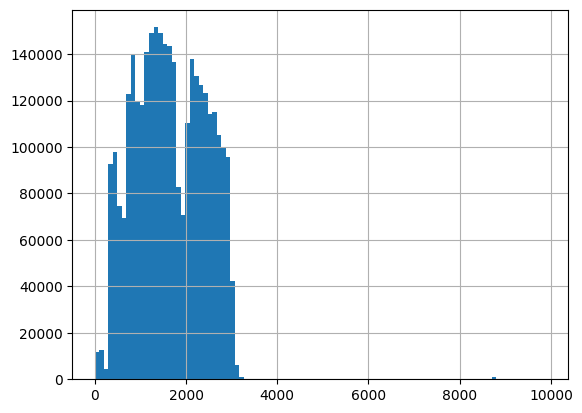

In [ ]:
df["Flight_Number_Operating_Airline"].hist(bins=100)

In [ ]:
len(df[df["Flight_Number_Operating_Airline"] < 25])

1528

In [ ]:
(1528 / len(df) )

0.0004712936517238614